<a href="https://colab.research.google.com/github/dingjun6953/Accelerate-Python-codes-using-proper-libraries/blob/main/PySpark_ML_Regression_Dingjun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 22.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=3930f7f19316278201ab6a2b1b4b119a11cdf32656cd6d9eb9422f277dd9e054
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [32]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import pandas as pd

Data analyses of BitstampUSD csv data file using the following 4 ML methods:

1. Linear Regression
2. Generalized Linear Regression
3. Gradient Boosted Tree Regression


Author: Dingjun Chen
Date: 2023/03/18

In [16]:
spark=SparkSession.builder.appName('PySpark_ML_Regression_Dingjun').getOrCreate()
df_bitcoin =spark.read.csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv',header=True,inferSchema=True)
df_bitcoin=df_bitcoin.na.drop(how="any")
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|
|1325534640| 5.0| 5.0| 5.0|  5.0|      19.048|            95.24|           5.0|
|1325591100|5.32|5.32|5.32| 5.32|  2.41917293|     12.869999988|          5.32|
|1325600520|5.14|5.14|5.14| 5.14|       

In [17]:
df_bitcoin.count()

3613769

In [18]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [19]:
featureassembler=VectorAssembler(inputCols=['Open','High', 'Low','Close','Volume_(BTC)','Volume_(Currency)'],outputCol="features")
output=featureassembler.transform(df_bitcoin)
finalized_data=output.select("features","Weighted_Price")
finalized_data.show()
     

+--------------------+--------------+
|            features|Weighted_Price|
+--------------------+--------------+
|[4.39,4.39,4.39,4...|          4.39|
|[4.39,4.39,4.39,4...|          4.39|
|[4.5,4.57,4.5,4.5...|  4.5264114983|
|[4.58,4.58,4.58,4...|          4.58|
|[4.58,4.58,4.58,4...|          4.58|
|[4.84,4.84,4.84,4...|          4.84|
|[5.0,5.0,5.0,5.0,...|           5.0|
|[5.0,5.0,5.0,5.0,...|           5.0|
|[5.32,5.32,5.32,5...|          5.32|
|[5.14,5.14,5.14,5...|          5.14|
|[5.26,5.26,5.26,5...|          5.26|
|[5.29,5.29,5.29,5...|          5.29|
|[5.29,5.29,5.29,5...|          5.29|
|[5.14,5.14,5.14,5...|          5.14|
|[5.29,5.29,5.29,5...|          5.29|
|[5.29,5.29,5.29,5...|          5.29|
|[4.93,4.93,4.93,4...|          4.93|
|[4.93,4.93,4.93,4...|          4.93|
|[5.19,5.19,5.19,5...|          5.19|
|[5.19,5.19,5.19,5...|          5.19|
+--------------------+--------------+
only showing top 20 rows



In [20]:
##train test split
train_data,test_data=finalized_data.randomSplit([0.75,0.25])     


**1. Linear Regression**

In [21]:
lr=LinearRegression(featuresCol='features', labelCol='Weighted_Price')
lr=lr.fit(train_data)   


In [22]:
tdata = lr.transform(test_data)
tdata.show(3)

rmse = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(tdata)
mae = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(tdata)
r2 = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(tdata)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[4.15,4.15,4.15,4...|          4.15|4.279355857961689|
|[4.23,4.23,4.23,4...|          4.23|4.352606869592602|
|[4.24,4.24,4.21,4...|  4.2184447962|4.334781682124955|
+--------------------+--------------+-----------------+
only showing top 3 rows

RMSE:  3.982799161130571
MAE:  1.5562797181405486
R-squared:  0.9999998034845409


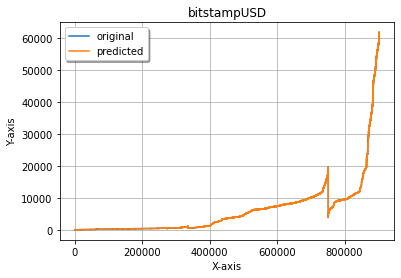

In [23]:
x_ax = range(0, tdata.count())
y_pred=tdata.select("prediction").collect()
y_orig=tdata.select("Weighted_Price").collect()
 
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("bitstampUSD")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 
     

**2.Generalized Linear Regression**

In [27]:
glr = GeneralizedLinearRegression(labelCol="Weighted_Price",family="gaussian", link="identity", maxIter=10, regParam=0.3)
glr = glr.fit(train_data)


In [28]:
tdata = glr.transform(test_data)
tdata.show(3)

rmse = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(tdata)
mae = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(tdata)
r2 = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(tdata)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[4.15,4.15,4.15,4...|          4.15|4.341468018752612|
|[4.23,4.23,4.23,4...|          4.23|4.417156772366522|
|[4.24,4.24,4.21,4...|  4.2184447962|4.404941923470783|
+--------------------+--------------+-----------------+
only showing top 3 rows

RMSE:  4.502875689674976
MAE:  1.6902811197392336
R-squared:  0.99999974881146


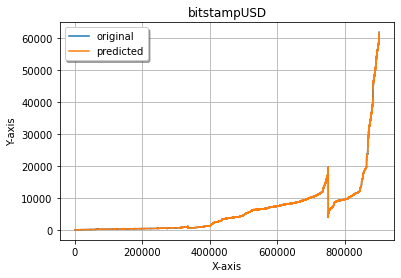

In [29]:
x_ax = range(0, tdata.count())
y_pred=tdata.select("prediction").collect()
y_orig=tdata.select("Weighted_Price").collect()
 
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("bitstampUSD")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

**3. Gradient Boosted Tree Regression**

In [24]:
gbtr = GBTRegressor(featuresCol='features', labelCol='Weighted_Price', maxIter=10)
gbtr = gbtr.fit(train_data)


In [25]:
tdata = gbtr.transform(test_data)
tdata.show(3)

rmse = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(tdata)
mae = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(tdata)
r2 = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(tdata)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[4.15,4.15,4.15,4...|          4.15|191.45703691939377|
|[4.23,4.23,4.23,4...|          4.23|191.45703691939377|
|[4.24,4.24,4.21,4...|  4.2184447962|191.45703691939377|
+--------------------+--------------+------------------+
only showing top 3 rows

RMSE:  1418.9214808456177
MAE:  481.4993769973928
R-squared:  0.9750576922621599


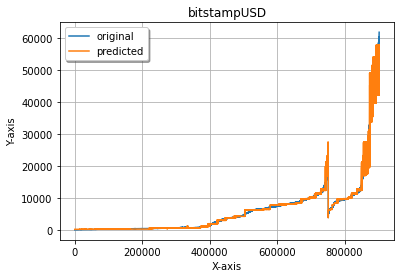

In [26]:
x_ax = range(0, tdata.count())
y_pred=tdata.select("prediction").collect()
y_orig=tdata.select("Weighted_Price").collect()
 
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("bitstampUSD")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 